# Testing Analytics Zoo AutoML experimental features

## Overview
We are interested in air quality prediction and have been looking for AutoML functionality that is capable of doing  AutoML supported prediction using multivariant input data. As part of our "research" into this we "discovered" Analytics Zoo. This Notebook explains what we did to test it out (and yes, we managed to get it working).

Analytics Zoo is a unified data analytics and AI platform open sourced by Intel. It is basically a complete environment (including Jupyter Notebook server) for ML. It is put together by bits and pieces already out there and for the AutoML experimental setup they have also connected it to a scalable backend using Ray and Apache Spark. The following image gives an overview of the Analytics Zoo setup for AutoML using a scalable backend based on Tensorflow, Keras, Ray and Apache Spark. The AutoML part is a layer on top of the backend and the individual use cases are in a thin App layer, e.g. TimeSequencePredictor, which is an "App" for multivariant input/single variant output time series prediction on top of the underlaying architecture.

![Analytics Zoo on Ray](AnalyticZooAutoML-overview.png)

## Prepare a Conda environment 
For the testing I did set up an Ubuntu 18.04 virtual machine with 32 cores and 100GB RAM. When the VM was ready I did install Anaconda first:
```
# Download Anaconda
curl -O https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
#Install Anaconda
bash Anaconda3-2019.10-Linux-x86_64.sh
```
I then created an Anaconda environment and populated it with the needed packages:

```
# Create a Conda environment and activate it
conda create -n zoo python=3.6
conda activate zoo

# Installed all necessary packages with Conda
conda install tensorflow
conda install -c anaconda scikit-learn
conda install -c conda-forge featuretools
conda install pandas
conda install matplotlib
conda install requests
conda install aiohttp psutil setproctitle grpcio
conda install -c conda-forge tabulate
conda install -c conda-forge setproctitle
conda install jupyter
conda install -c anaconda openjdk=8.0.152

# Use pip to install the rest of the packages (that are not supported by conda)
pip install pyspark==2.4.3
pip install ray==0.6.6
```


## Get and compile the AnalyticsZoo AutoML package
To get the experimental AnalyticsZoo AutoML package we need to download and compile the source code for the AutoML branch. In order to do that we also need Maven:
```
sudo apt install maven
```

```
# Clone repo autoML branch
git clone --single-branch --branch automl https://github.com/intel-analytics/analytics-zoo.git

# Compile the AutoML branch (for linux) with Spark support (all the -D options)
bash analytics-zoo/pyzoo/dev/build.sh linux default -Dspark.version=2.4.3 -Dbigdl.artifactId=bigdl-SPARK_2.4 -P spark_2.4+

```
Install the newly compiled Analytics Zoo package (se above)
```
pip install analytics-zoo/pyzoo/dist/analytics_zoo-0.6.0.dev0-py2.py3-none-manylinux1_x86_64.whl
```

## Run the example
The example is based on this [article](https://medium.com/riselab/scalable-automl-for-time-series-prediction-using-ray-and-analytics-zoo-b79a6fd08139) (and the related Notebook) but uses air quality and Met.no data from Trondheim instead of taxi ride data from NYC.

In [37]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", test_value_col="value", pred_value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[pred_value_col].values
    true_value = test_df[test_value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('PM 2.5')
    plt.legend(loc='upper left')
    plt.show()

In [41]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('PM 2.5')
    plt.legend(loc='upper left')
    plt.show()

In [42]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('PM 2.5')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [5]:
# load airquality data
try:
    df = pd.read_csv('airquality_prepared.csv.xz', parse_dates=['fromTime'])
except Exception as e:
    print("airquality.csv.xz doesn't exist")

In [6]:
df.dtypes

fromTime                                         datetime64[ns, UTC]
NO0060A.PM10                                                 float64
NO0060A.PM2.5                                                float64
SN68860:0.air_temperature                                    float64
SN68860:0.relative_humidity                                  float64
SN68860:0.sum(duration_of_precipitation PT1H)                float64
SN68860:0.sum(precipitation_amount PT1H)                     float64
SN68860:0.surface_air_pressure                               float64
SN68860:0.wind_from_direction                                float64
SN68860:0.wind_speed                                         float64
dtype: object

In [7]:
df.head()

fromTime  NO0060A.PM10  NO0060A.PM2.5  \
0 2018-09-01 00:00:00+00:00     16.212345       6.610888   
1 2018-09-01 01:00:00+00:00     13.058908       4.298377   
2 2018-09-01 02:00:00+00:00     13.483383       3.751450   
3 2018-09-01 03:00:00+00:00      9.141075       2.598822   
4 2018-09-01 04:00:00+00:00      4.820948       0.048310   

   SN68860:0.air_temperature  SN68860:0.relative_humidity  \
0                        8.0                         79.0   
1                        8.0                         80.0   
2                        7.0                         80.0   
3                        7.0                         75.0   
4                        7.0                         80.0   

   SN68860:0.sum(duration_of_precipitation PT1H)  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   SN68860:0.sum(precipitation_amount PT1H)  SN68860:0.surface_air_pressure  \
0                                       0.0                          1006.0   
1                                       0.0                          1006.0   
2                                       0.0                          1006.0   
3                                       0.0                          1006.0   
4                                       0.0                          1006.0   

   SN68860:0.wind_from_direction  SN68860:0.wind_speed  
0                          150.0                   1.0  
1                          153.0                   0.0  
2                           30.0                   0.0  
3                          149.0                   1.0  
4                           92.0                   0.0

In [8]:
df['fromTime'] = df['fromTime'].dt.tz_convert(None)

In [9]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, ts_col="fromTime", val_split_ratio=0.1, test_split_ratio=0.1)

Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [10]:
train_df.describe()

NO0060A.PM10  NO0060A.PM2.5  SN68860:0.air_temperature  \
count   8180.000000    8180.000000                8180.000000   
mean      12.443637       5.510887                   5.541687   
std       12.690607       6.284173                   7.149469   
min       -4.218054      -4.891530                 -13.000000   
25%        4.621233       2.016871                   0.000000   
50%        9.047965       4.059862                   5.000000   
75%       15.741199       6.714201                  10.000000   
max      197.929553      72.163923                  31.000000   

       SN68860:0.relative_humidity  \
count                  8180.000000   
mean                     75.167115   
std                      15.939297   
min                      20.000000   
25%                      64.000000   
50%                      79.000000   
75%                      88.000000   
max                      99.000000   

       SN68860:0.sum(duration_of_precipitation PT1H)  \
count                                    8180.000000   
mean                                       23.751670   
std                                        24.272789   
min                                         0.000000   
25%                                         0.000000   
50%                                        16.000000   
75%                                        49.000000   
max                                        60.000000   

       SN68860:0.sum(precipitation_amount PT1H)  \
count                               8180.000000   
mean                                   0.047311   
std                                    0.288062   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    0.000000   
max                                    7.000000   

       SN68860:0.surface_air_pressure  SN68860:0.wind_from_direction  \
count                     8180.000000                    8180.000000   
mean                       994.725697                     180.864378   
std                         11.900986                      86.069364   
min                        958.000000                       0.000000   
25%                        988.000000                     123.000000   
50%                        995.000000                     200.000000   
75%                       1002.000000                     229.000000   
max                       1026.000000                     360.000000   

       SN68860:0.wind_speed  
count           8180.000000  
mean               2.103178  
std                1.652280  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
max               12.000000

In [11]:
train_df.head(5)

datetime  NO0060A.PM10  NO0060A.PM2.5  SN68860:0.air_temperature  \
0 2018-09-01 00:00:00     16.212345       6.610888                        8.0   
1 2018-09-01 01:00:00     13.058908       4.298377                        8.0   
2 2018-09-01 02:00:00     13.483383       3.751450                        7.0   
3 2018-09-01 03:00:00      9.141075       2.598822                        7.0   
4 2018-09-01 04:00:00      4.820948       0.048310                        7.0   

   SN68860:0.relative_humidity  SN68860:0.sum(duration_of_precipitation PT1H)  \
0                         79.0                                            0.0   
1                         80.0                                            0.0   
2                         80.0                                            0.0   
3                         75.0                                            0.0   
4                         80.0                                            0.0   

   SN68860:0.sum(precipitation_amount PT1H)  SN68860:0.surface_air_pressure  \
0                                       0.0                          1006.0   
1                                       0.0                          1006.0   
2                                       0.0                          1006.0   
3                                       0.0                          1006.0   
4                                       0.0                          1006.0   

   SN68860:0.wind_from_direction  SN68860:0.wind_speed  
0                          150.0                   1.0  
1                          153.0                   0.0  
2                           30.0                   0.0  
3                          149.0                   1.0  
4                           92.0                   0.0

In [12]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8180, 10)
The shape of val_df is (1022, 10)
The shape of test_df is (1022, 10)


No handles with labels found to put in legend.


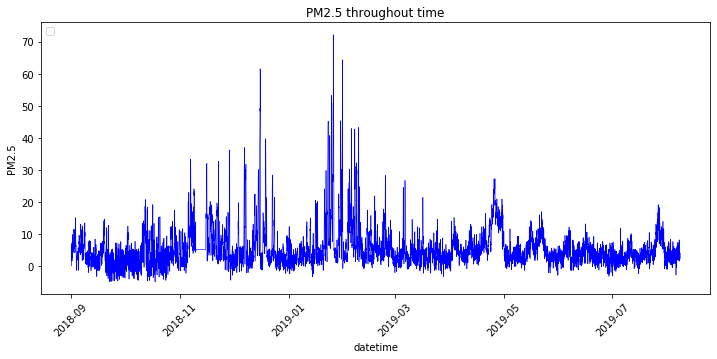

In [13]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['NO0060A.PM2.5'], color='blue', linewidth=0.6)
ax.set_title('PM2.5 throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('PM2.5')
plt.legend(loc='upper left')
plt.show()

In [14]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# The future_seq_len is number of timesteps to predict, 24 is 24 hours
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="NO0060A.PM2.5",
                            future_seq_len=24,
                            extra_features_col=["SN68860:0.air_temperature", "SN68860:0.relative_humidity", "SN68860:0.sum(duration_of_precipitation PT1H)", "SN68860:0.sum(precipitation_amount PT1H)", "SN68860:0.surface_air_pressure", "SN68860:0.wind_from_direction", "SN68860:0.wind_speed"])

In [15]:
from zoo.ray.util.raycontext import RayContext
from zoo import init_spark_on_local

sc = init_spark_on_local(cores=28)
ray_ctx = RayContext(sc=sc)

Current pyspark location is : /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched


In [16]:
ray_ctx.init()

Start to launch ray on cluster
Start to launch ray on local


In [17]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
# look_back is how far back (timesteps) in the dataset to look when training (min, max). so for our data, 24 is 24 hours.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   resources_per_trial={"cpu": 10},
                   recipe=GridRandomRecipe(num_rand_samples=10, look_back=(120, 240)))
print("Training completed.")

2020-03-02 11:33:59,667	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-03-02 11:33:59,668	INFO tune.py:211 -- Starting a new experiment.
2020-03-02 11:33:59,840	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.7/101.4 GB

(pid=3153) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=3153) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=3161) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=3161) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=3162) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=3162) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=3156) Prepending /home/arneme/anaconda3/envs/zoo/lib/py

2020-03-02 11:33:59,945	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 4.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 1, 'PENDING': 79})
PENDING trials:
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_speed' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS

(pid=3163) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3163) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3163) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3163) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3163) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3163) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3163) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3163) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3163) OMP: Inf

(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3349 thread 25 bound to OS proc set 25
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3365 thread 26 bound to OS proc set 26
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3376 thread 27 bound to OS proc set 27
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3348 thread 28 bound to OS proc set 28
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3350 thread 29 bound to OS proc set 29
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3359 thread 30 bound to OS proc set 30
(pid=3163) OMP: Info #251: KMP_AFFINITY: pid 3163 tid 3363 thread 31 bound to OS proc set 31
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,pa

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BU

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BU

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BU

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BU

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_B

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_B

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'RUNNING': 2, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_B

2020-03-02 11:39:21,837	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 78})
PENDING trials:
 - train_func_2_dropout_2=0.21425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=156,selected_features=['SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selecte

(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3926 thread 23 bound to OS proc set 23
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3922 thread 24 bound to OS proc set 24
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3923 thread 25 bound to OS proc set 25
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3918 thread 26 bound to OS proc set 26
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3925 thread 27 bound to OS proc set 27
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3920 thread 28 bound to OS proc set 28
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3935 thread 29 bound to OS proc set 29
(pid=3077) OMP: Info #251: KMP_AFFINITY: pid 3077 tid 3921 thread 30 bound to OS proc set 30


2020-03-02 11:39:39,168	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 77})
PENDING trials:
 - train_func_3_dropout_2=0.34476,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_featur

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 2, 'RUNNING': 2, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

2020-03-02 11:44:14,798	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 3, 'RUNNING': 1, 'PENDING': 76})
PENDING trials:
 - train_func_4_dropout_2=0.20945,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=189,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'MONTH(datetime)']:	PENDING
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 3, 'RUNNING': 2, 'PENDING': 75})
PENDING trials:
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 3, 'RUNNING': 2, 'PENDING': 75})
PENDING trials:
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 3, 'RUNNING': 2, 'PENDING': 75})
PENDING trials:
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model

2020-03-02 11:47:53,483	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 1, 'PENDING': 75})
PENDING trials:
 - train_func_5_dropout_2=0.36001,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=162,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model

(pid=3164) OMP: Info #251: KMP_AFFINITY: pid 3164 tid 4704 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitatio

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 4, 'RUNNING': 2, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

2020-03-02 11:56:03,747	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 5, 'RUNNING': 1, 'PENDING': 74})
PENDING trials:
 - train_func_6_dropout_2=0.25799,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=200,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 5, 'RUNNING': 2, 'PENDING': 73})
PENDING trials:
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=[

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 5, 'RUNNING': 2, 'PENDING': 73})
PENDING trials:
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=[

2020-03-02 11:58:14,496	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 1, 'PENDING': 73})
PENDING trials:
 - train_func_7_dropout_2=0.42035,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=160,selected_features=['SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=[

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 6, 'RUNNING': 2, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

2020-03-02 12:08:27,730	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 7, 'RUNNING': 1, 'PENDING': 72})
PENDING trials:
 - train_func_8_dropout_2=0.27046,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=201,selected_features=['DAY(datetime)' 'HOUR(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed']:	PENDING
 - train_func_9_dropout_2=0.44265,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=125,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_AWAKE(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(d

2020-03-02 12:08:28,619	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=3088) 2020-03-02 12:08:30.326259: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=3088) LSTM is selected.
(pid=3088) 2020-03-02 12:08:30.334584: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=3088) 2020-03-02 12:08:30.337196: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf0459f2d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=3088) 2020-03-02 12:08:30.337224: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=3088) 2020-03-02 12:08:30.337334: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=3155) 2020-03-02 12:08:31.105134: I tensorflow/core/platform/cpu_featu

(pid=3155) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3155) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3155) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3155) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3155) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3155) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3155) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3155) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3155) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 8, 'RUNNING': 2, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

2020-03-02 12:12:33,999	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 9, 'RUNNING': 1, 'PENDING': 70})
PENDING trials:
 - train_func_10_dropout_2=0.42214,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['HOUR(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,ls

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 9, 'RUNNING': 2, 'PENDING': 69})
PENDING trials:
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=

2020-03-02 12:13:13,438	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 1, 'PENDING': 69})
PENDING trials:
 - train_func_11_dropout_2=0.40865,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=210,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units

(pid=3086) OMP: Info #251: KMP_AFFINITY: pid 3086 tid 6428 thread 26 bound to OS proc set 26
(pid=3086) OMP: Info #251: KMP_AFFINITY: pid 3086 tid 6431 thread 27 bound to OS proc set 27
(pid=3086) OMP: Info #251: KMP_AFFINITY: pid 3086 tid 6409 thread 28 bound to OS proc set 28
(pid=3086) OMP: Info #251: KMP_AFFINITY: pid 3086 tid 6411 thread 29 bound to OS proc set 29
(pid=3086) OMP: Info #251: KMP_AFFINITY: pid 3086 tid 6413 thread 30 bound to OS proc set 30
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 10, 'RUNNING': 2, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(dateti

2020-03-02 12:19:16,682	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 11, 'RUNNING': 1, 'PENDING': 68})
PENDING trials:
 - train_func_12_dropout_2=0.28731,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=120,selected_features=['SN68860:0.relative_humidity' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(dateti

(pid=3156) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3156) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3156) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3156) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3156) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3156) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3156) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3156) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3156) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 11, 'RUNNING': 2, 'PENDING': 67})
PENDING trials:
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)'

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 11, 'RUNNING': 2, 'PENDING': 67})
PENDING trials:
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)'

2020-03-02 12:21:16,894	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 1, 'PENDING': 67})
PENDING trials:
 - train_func_13_dropout_2=0.4223,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=233,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.air_temperature' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)'

(pid=3087) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3087) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3087) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3087) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3087) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3087) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3087) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3087) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3087) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 2, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 2, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 2, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 2, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 12, 'RUNNING': 2, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

2020-03-02 12:27:28,724	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 1, 'PENDING': 66})
PENDING trials:
 - train_func_14_dropout_2=0.42915,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=156,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_

(pid=3161) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3161) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3161) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3161) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3161) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3161) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3161) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3161) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3161) OMP: Inf

(pid=3161) OMP: Info #251: KMP_AFFINITY: pid 3161 tid 7373 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 2, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 12.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 2, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 12.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 2, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 12.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 2, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 12.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 13, 'RUNNING': 2, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:

2020-03-02 12:35:26,574	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 12.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 14, 'RUNNING': 1, 'PENDING': 65})
PENDING trials:
 - train_func_15_dropout_2=0.23659,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=223,selected_features=['MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:

(pid=3081) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3081) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3081) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3081) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3081) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3081) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3081) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3081) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3081) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 14, 'RUNNING': 2, 'PENDING': 64})
PENDING trials:
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:	PENDING
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1

2020-03-02 12:37:33,474	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 1, 'PENDING': 64})
PENDING trials:
 - train_func_16_dropout_2=0.40645,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=173,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_from_direction'
 'SN68860:0.air_temperature']:	PENDING
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1

(pid=3158) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3158) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3158) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3158) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3158) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3158) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3158) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3158) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3158) OMP: Inf

(pid=3158) OMP: Info #251: KMP_AFFINITY: pid 3158 tid 7888 thread 30 bound to OS proc set 30
(pid=3158) OMP: Info #251: KMP_AFFINITY: pid 3158 tid 7900 thread 31 bound to OS proc set 31
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 2, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units

(pid=3158) OMP: Info #251: KMP_AFFINITY: pid 3158 tid 7906 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 2, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitatio

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 2, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AW

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 2, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AW

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 15, 'RUNNING': 2, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AW

2020-03-02 12:41:50,684	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 1, 'PENDING': 63})
PENDING trials:
 - train_func_17_dropout_2=0.33571,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=126,selected_features=['DAY(datetime)' 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AW

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 16, 'RUNNING': 2, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

2020-03-02 12:45:52,401	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 17, 'RUNNING': 1, 'PENDING': 62})
PENDING trials:
 - train_func_18_dropout_2=0.49365,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=216,selected_features=['SN68860:0.air_temperature' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.su

(pid=3150) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3150) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3150) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3150) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3150) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3150) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3150) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3150) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3150) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 17, 'RUNNING': 2, 'PENDING': 61})
PENDING trials:
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 17, 'RUNNING': 2, 'PENDING': 61})
PENDING trials:
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['

2020-03-02 12:49:20,383	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 18, 'RUNNING': 1, 'PENDING': 61})
PENDING trials:
 - train_func_19_dropout_2=0.40398,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=135,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=[

(pid=3082) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3082) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3082) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3082) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3082) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3082) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3082) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3082) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3082) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 18, 'RUNNING': 2, 'PENDING': 60})
PENDING trials:
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 18, 'RUNNING': 2, 'PENDING': 60})
PENDING trials:
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 18, 'RUNNING': 2, 'PENDING': 60})
PENDING trials:
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 18, 'RUNNING': 2, 'PENDING': 60})
PENDING trials:
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68

2020-03-02 12:52:28,221	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 19, 'RUNNING': 1, 'PENDING': 60})
PENDING trials:
 - train_func_20_dropout_2=0.45669,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=163,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68

(pid=3159) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3159) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3159) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3159) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3159) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3159) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3159) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3159) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3159) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 19, 'RUNNING': 2, 'PENDING': 59})
PENDING trials:
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_drop

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 19, 'RUNNING': 2, 'PENDING': 59})
PENDING trials:
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_drop

2020-03-02 12:54:34,629	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 1, 'PENDING': 59})
PENDING trials:
 - train_func_21_dropout_2=0.46906,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=130,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.wind_from_direction'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_drop

(pid=3084) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3084) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3084) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3084) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3084) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3084) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3084) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3084) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3084) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 20, 'RUNNING': 2, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

2020-03-02 13:02:59,176	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 21, 'RUNNING': 1, 'PENDING': 58})
PENDING trials:
 - train_func_22_dropout_2=0.24459,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=120,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'DAY(datetime)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)']:	PENDING
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(dateti

(pid=3157) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3157) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3157) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3157) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3157) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3157) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3157) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3157) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3157) OMP: Inf

2020-03-02 13:03:15,561	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 1, 'PENDING': 57})
PENDING trials:
 - train_func_23_dropout_2=0.41516,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=175,selected_features=['SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEE

(pid=3157) OMP: Info #251: KMP_AFFINITY: pid 3157 tid 9789 thread 31 bound to OS proc set 31
(pid=3080) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3080) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3080) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3080) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3080) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3080) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3080) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3080) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3080) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3080) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3080) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3080) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(p

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 '

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 22, 'RUNNING': 2, 'PENDING': 56})
PENDING trials:
 - train_func_24_dropout_2=0.40479,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.air_temperature' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'HOUR(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 

2020-03-02 13:11:12,017	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=3154) LSTM is selected.
(pid=3154) 2020-03-02 13:11:14.901700: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=3154) 2020-03-02 13:11:14.910936: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=3154) 2020-03-02 13:11:14.913547: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6d044816c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=3154) 2020-03-02 13:11:14.913579: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=3154) 2020-03-02 13:11:14.914969: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=3154) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 23, 'RUNNING': 2, 'PENDING': 55})
PENDING trials:
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_units

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 23, 'RUNNING': 2, 'PENDING': 55})
PENDING trials:
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_units

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 23, 'RUNNING': 2, 'PENDING': 55})
PENDING trials:
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_unit

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 23, 'RUNNING': 2, 'PENDING': 55})
PENDING trials:
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_unit

2020-03-02 13:14:28,487	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 24, 'RUNNING': 1, 'PENDING': 55})
PENDING trials:
 - train_func_25_dropout_2=0.40882,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=153,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_unit

(pid=3074) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3074) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3074) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3074) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3074) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3074) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3074) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3074) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3074) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 24, 'RUNNING': 2, 'PENDING': 54})
PENDING trials:
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN688

2020-03-02 13:15:17,964	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 1, 'PENDING': 54})
PENDING trials:
 - train_func_26_dropout_2=0.44647,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=142,selected_features=['IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN688

(pid=10812) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=10812) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=10812) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=10812) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=10812) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=10812) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=10812) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=10812) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 25, 'RUNNING': 2, 'PENDING': 53})
PENDING trials:
 - train_func_27_dropout_2=0.33876,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=218,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind

2020-03-02 13:19:22,678	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=3079) LSTM is selected.
(pid=3079) 2020-03-02 13:19:25.264136: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=3079) 2020-03-02 13:19:25.272651: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=3079) 2020-03-02 13:19:25.276069: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6b1458e160 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=3079) 2020-03-02 13:19:25.276096: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=3079) 2020-03-02 13:19:25.276344: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=3079) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3

2020-03-02 13:19:48,002	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 1, 'PENDING': 52})
PENDING trials:
 - train_func_28_dropout_2=0.42551,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=166,selected_features=['SN68860:0.wind_speed' 'HOUR(datetime)' 'SN68860:0.relative_humidity'
 'DAY(datetime)' 'MONTH(datetime)' 'WEEKDAY(datetime)']:	PENDING
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' '

(pid=10815) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=10815) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=10815) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=10815) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=10815) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=10815) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=10815) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=10815) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 27, 'RUNNING': 2, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

2020-03-02 13:27:39,829	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 28, 'RUNNING': 1, 'PENDING': 51})
PENDING trials:
 - train_func_29_dropout_2=0.37888,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=192,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,

(pid=3085) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=3085) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=3085) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=3085) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=3085) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=3085) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=3085) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=3085) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=3085) OMP: Inf

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 28, 'RUNNING': 2, 'PENDING': 50})
PENDING trials:
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PEND

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 28, 'RUNNING': 2, 'PENDING': 50})
PENDING trials:
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PEND

2020-03-02 13:30:29,363	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 1, 'PENDING': 50})
PENDING trials:
 - train_func_30_dropout_2=0.48245,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)' 'DAY(datetime)' 'IS_AWAKE(datetime)'
 'MONTH(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'HOUR(datetime)']:	PENDING
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PEND

(pid=12010) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=12010) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=12010) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=12010) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=12010) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=12010) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=12010) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=12010) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 29, 'RUNNING': 2, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

2020-03-02 13:39:39,417	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 30, 'RUNNING': 1, 'PENDING': 49})
PENDING trials:
 - train_func_31_dropout_2=0.39707,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=129,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'SN68860:0.sum(precipitation_amount PT1H)'
 'WEEKDAY(datetime)' 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_32_dropout_2=0.34389,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=228,selected_features=['SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'IS_WEEKEND(datetime)' 'MONTH(datetime)' 'SN68860:0.wind_speed'
 'DAY(datetime)']:	PENDING
 - train_func_33_dropout_2=0.428,lstm

2020-03-02 13:39:43,867	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=12455) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=12455) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=12455) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=12455) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=12455) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=12455) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=12455) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=12455) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12653 thread 21 bound to OS proc set 21
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12665 thread 22 bound to OS proc set 22
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12666 thread 23 bound to OS proc set 23
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12669 thread 24 bound to OS proc set 24
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12661 thread 25 bound to OS proc set 25
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12652 thread 26 bound to OS proc set 26
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12671 thread 27 bound to OS proc set 27
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12681 thread 28 bound to OS proc set 28
(pid=12013) OMP: Info #251: KMP_AFFINITY: pid 12013 tid 12654 thread 29 bound to OS proc set 29
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this n

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 31, 'RUNNING': 2, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

2020-03-02 13:45:12,074	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 32, 'RUNNING': 1, 'PENDING': 47})
PENDING trials:
 - train_func_33_dropout_2=0.428,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=198,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_from_direction'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selec

(pid=12981) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=12981) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=12981) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=12981) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=12981) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=12981) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=12981) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=12981) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 32, 'RUNNING': 2, 'PENDING': 46})
PENDING trials:
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 32, 'RUNNING': 2, 'PENDING': 46})
PENDING trials:
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 32, 'RUNNING': 2, 'PENDING': 46})
PENDING trials:
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_f

2020-03-02 13:48:32,103	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 33, 'RUNNING': 1, 'PENDING': 46})
PENDING trials:
 - train_func_34_dropout_2=0.39366,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=123,selected_features=['IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'MONTH(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_f

(pid=12458) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=12458) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=12458) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=12458) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=12458) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=12458) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=12458) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=12458) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 33, 'RUNNING': 2, 'PENDING': 45})
PENDING trials:
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_se

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 33, 'RUNNING': 2, 'PENDING': 45})
PENDING trials:
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_se

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 33, 'RUNNING': 2, 'PENDING': 45})
PENDING trials:
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_se

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 33, 'RUNNING': 2, 'PENDING': 45})
PENDING trials:
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_se

2020-03-02 13:51:27,762	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 34, 'RUNNING': 1, 'PENDING': 45})
PENDING trials:
 - train_func_35_dropout_2=0.34374,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=151,selected_features=['SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'SN68860:0.wind_from_direction' 'WEEKDAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_se

(pid=12984) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=12984) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=12984) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=12984) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=12984) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=12984) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=12984) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=12984) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 34, 'RUNNING': 2, 'PENDING': 44})
PENDING trials:
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'

2020-03-02 13:52:25,603	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 1, 'PENDING': 44})
PENDING trials:
 - train_func_36_dropout_2=0.29337,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'

(pid=13780) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=13780) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=13780) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=13780) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=13780) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=13780) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=13780) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=13780) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 2, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 2, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 2, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 2, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 35, 'RUNNING': 2, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

2020-03-02 13:57:16,358	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 1, 'PENDING': 43})
PENDING trials:
 - train_func_37_dropout_2=0.49585,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=164,selected_features=['SN68860:0.relative_humidity' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_

(pid=14124) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=14124) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=14124) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=14124) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=14124) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=14124) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=14124) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=14124) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 36, 'RUNNING': 2, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

2020-03-02 14:05:24,224	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 37, 'RUNNING': 1, 'PENDING': 42})
PENDING trials:
 - train_func_38_dropout_2=0.44672,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=139,selected_features=['SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'SN68860:0.wind_speed'
 'IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'DAY(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)']:	PENDING
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation P

(pid=13783) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=13783) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=13783) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=13783) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=13783) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=13783) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=13783) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=13783) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 37, 'RUNNING': 2, 'PENDING': 41})
PENDING trials:
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,mo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 37, 'RUNNING': 2, 'PENDING': 41})
PENDING trials:
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,mo

2020-03-02 14:07:48,168	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 1, 'PENDING': 41})
PENDING trials:
 - train_func_39_dropout_2=0.21919,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=195,selected_features=['SN68860:0.surface_air_pressure' 'HOUR(datetime)'
 'SN68860:0.relative_humidity' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,mo

(pid=14127) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=14127) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=14127) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=14127) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=14127) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=14127) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=14127) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=14127) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 2, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 2, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 2, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 2, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 38, 'RUNNING': 2, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'


2020-03-02 14:14:37,599	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 39, 'RUNNING': 1, 'PENDING': 40})
PENDING trials:
 - train_func_40_dropout_2=0.4987,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=162,selected_features=['SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'HOUR(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'


(pid=15101) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=15101) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=15101) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=15101) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=15101) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=15101) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=15101) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=15101) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

(pid=15101) OMP: Info #251: KMP_AFFINITY: pid 15101 tid 15211 thread 30 bound to OS proc set 30
(pid=15101) OMP: Info #251: KMP_AFFINITY: pid 15101 tid 15189 thread 31 bound to OS proc set 31
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 39, 'RUNNING': 2, 'PENDING': 39})
PENDING trials:
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' '

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 39, 'RUNNING': 2, 'PENDING': 39})
PENDING trials:
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_feature

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 39, 'RUNNING': 2, 'PENDING': 39})
PENDING trials:
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_feature

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 39, 'RUNNING': 2, 'PENDING': 39})
PENDING trials:
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_feature

2020-03-02 14:18:42,400	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 40, 'RUNNING': 1, 'PENDING': 39})
PENDING trials:
 - train_func_41_dropout_2=0.42862,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=215,selected_features=['IS_WEEKEND(datetime)' 'DAY(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_feature

(pid=15104) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=15104) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=15104) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=15104) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=15104) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=15104) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=15104) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=15104) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

(pid=15104) OMP: Info #251: KMP_AFFINITY: pid 15104 tid 15553 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 40, 'RUNNING': 2, 'PENDING': 38})
PENDING trials:
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_h

2020-03-02 14:20:03,090	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 1, 'PENDING': 38})
PENDING trials:
 - train_func_42_dropout_2=0.21297,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=145,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.wind_speed' 'IS_AWAKE(datetime)'
 'SN68860:0.relative_humidity' 'WEEKDAY(datetime)']:	PENDING
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 41, 'RUNNING': 2, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

2020-03-02 14:24:39,016	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 42, 'RUNNING': 1, 'PENDING': 37})
PENDING trials:
 - train_func_43_dropout_2=0.23041,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_from_direction' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.wind_speed' 'IS_WEEKEND(datetime)' 'DAY(datetime)'
 'SN68860:0.surface_air_pressure' 'HOUR(datetime)']:	PENDING
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68

(pid=15638) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=15638) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=15638) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=15638) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=15638) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=15638) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=15638) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=15638) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

2020-03-02 14:25:24,705	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 1, 'PENDING': 36})
PENDING trials:
 - train_func_44_dropout_2=0.43308,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=208,selected_features=['IS_AWAKE(datetime)' 'DAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,mo

(pid=16205) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=16205) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=16205) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=16205) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=16205) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=16205) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=16205) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=16205) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

(pid=16205) OMP: Info #251: KMP_AFFINITY: pid 16205 tid 16295 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_le

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN6886

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN688

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN688

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN688

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 43, 'RUNNING': 2, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN688

2020-03-02 14:32:34,924	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 44, 'RUNNING': 1, 'PENDING': 35})
PENDING trials:
 - train_func_45_dropout_2=0.3964,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_speed' 'MONTH(datetime)' 'SN68860:0.relative_humidity'
 'SN68860:0.air_temperature' 'DAY(datetime)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN688

(pid=16599) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=16599) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=16599) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=16599) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=16599) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=16599) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=16599) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=16599) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 44, 'RUNNING': 2, 'PENDING': 34})
PENDING trials:
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 44, 'RUNNING': 2, 'PENDING': 34})
PENDING trials:
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 44, 'RUNNING': 2, 'PENDING': 34})
PENDING trials:
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 44, 'RUNNING': 2, 'PENDING': 34})
PENDING trials:
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_f

2020-03-02 14:38:22,902	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 1, 'PENDING': 34})
PENDING trials:
 - train_func_46_dropout_2=0.4086,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'HOUR(datetime)']:	PENDING
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 2, 'PENDING': 33})
PENDING trials:
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 2, 'PENDING': 33})
PENDING trials:
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 2, 'PENDING': 33})
PENDING trials:
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 2, 'PENDING': 33})
PENDING trials:
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 45, 'RUNNING': 2, 'PENDING': 33})
PENDING trials:
 - train_func_47_dropout_2=0.35528,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=235,selected_features=['SN68860:0.wind_speed' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860

2020-03-02 14:45:22,668	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=16602) 2020-03-02 14:45:25.174600: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=16602) Seq2seq is selected.
(pid=16602) 2020-03-02 14:45:25.184861: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=16602) 2020-03-02 14:45:25.188144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f16202795d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=16602) 2020-03-02 14:45:25.188186: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=16602) 2020-03-02 14:45:25.188408: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=16602) OMP: Info #154: KMP_AFFINITY: Initial OS proc set resp

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 46, 'RUNNING': 2, 'PENDING': 32})
PENDING trials:
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,sele

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 46, 'RUNNING': 2, 'PENDING': 32})
PENDING trials:
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,sele

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 46, 'RUNNING': 2, 'PENDING': 32})
PENDING trials:
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,sele

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 46, 'RUNNING': 2, 'PENDING': 32})
PENDING trials:
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,sele

2020-03-02 14:52:08,251	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 1, 'PENDING': 32})
PENDING trials:
 - train_func_48_dropout_2=0.40508,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.wind_speed'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,sele

(pid=17482) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=17482) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=17482) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=17482) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=17482) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=17482) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=17482) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=17482) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 47, 'RUNNING': 2, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

2020-03-02 14:57:01,526	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 48, 'RUNNING': 1, 'PENDING': 31})
PENDING trials:
 - train_func_49_dropout_2=0.35246,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=174,selected_features=['IS_BUSY_HOURS(datetime)' 'HOUR(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)']:	PENDING
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 48, 'RUNNING': 2, 'PENDING': 30})
PENDING trials:
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipita

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 48, 'RUNNING': 2, 'PENDING': 30})
PENDING trials:
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipita

2020-03-02 14:59:43,458	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 1, 'PENDING': 30})
PENDING trials:
 - train_func_50_dropout_2=0.46081,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=215,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_WEEKEND(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipita

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 2, 'PENDING': 29})
PENDING trials:
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_a

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 2, 'PENDING': 29})
PENDING trials:
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_a

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 2, 'PENDING': 29})
PENDING trials:
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_a

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 2, 'PENDING': 29})
PENDING trials:
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_a

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 49, 'RUNNING': 2, 'PENDING': 29})
PENDING trials:
 - train_func_51_dropout_2=0.34656,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=196,selected_features=['DAY(datetime)' 'WEEKDAY(datetime)' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_a

2020-03-02 15:02:28,274	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=18370) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=18370) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=18373) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=18373) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=18370) LSTM is selected.
(pid=18370) 2020-03-02 15:02:31.800822: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=18370) 2020-03-02 15:02:31.809745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=18370) 2020-03-02 15:02:31.812088: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0

(pid=18370) OMP: Info #251: KMP_AFFINITY: pid 18370 tid 18456 thread 30 bound to OS proc set 30
(pid=18370) OMP: Info #251: KMP_AFFINITY: pid 18370 tid 18459 thread 31 bound to OS proc set 31
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 50, 'RUNNING': 2, 'PENDING': 28})
PENDING trials:
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relativ

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 50, 'RUNNING': 2, 'PENDING': 28})
PENDING trials:
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 50, 'RUNNING': 2, 'PENDING': 28})
PENDING trials:
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 50, 'RUNNING': 2, 'PENDING': 28})
PENDING trials:
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amo

2020-03-02 15:06:18,089	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 51, 'RUNNING': 1, 'PENDING': 28})
PENDING trials:
 - train_func_52_dropout_2=0.45579,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=226,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amo

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 51, 'RUNNING': 2, 'PENDING': 27})
PENDING trials:
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MON

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 51, 'RUNNING': 2, 'PENDING': 27})
PENDING trials:
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MON

2020-03-02 15:10:00,920	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 1, 'PENDING': 27})
PENDING trials:
 - train_func_53_dropout_2=0.49239,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=145,selected_features=['SN68860:0.surface_air_pressure'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.wind_speed'
 'IS_BUSY_HOURS(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MON

(pid=18373) OMP: Info #251: KMP_AFFINITY: pid 18373 tid 19027 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,p

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 52, 'RUNNING': 2, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

2020-03-02 15:19:33,888	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 53, 'RUNNING': 1, 'PENDING': 26})
PENDING trials:
 - train_func_54_dropout_2=0.21066,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=207,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'MONTH(datetime)' 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(

(pid=19363) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=19363) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=19363) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=19363) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=19363) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=19363) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=19363) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=19363) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

2020-03-02 15:20:09,195	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 1, 'PENDING': 25})
PENDING trials:
 - train_func_55_dropout_2=0.41288,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=161,selected_features=['WEEKDAY(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'DAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LS

(pid=19498) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=19498) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=19498) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=19498) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=19498) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=19498) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=19498) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=19498) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=1

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 54, 'RUNNING': 2, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

2020-03-02 15:30:31,841	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 55, 'RUNNING': 1, 'PENDING': 24})
PENDING trials:
 - train_func_56_dropout_2=0.24039,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=206,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'WEEKDAY(datetime)']:	PENDING
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 55, 'RUNNING': 2, 'PENDING': 23})
PENDING trials:
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN6886

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 55, 'RUNNING': 2, 'PENDING': 23})
PENDING trials:
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN6886

2020-03-02 15:32:25,802	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 1, 'PENDING': 23})
PENDING trials:
 - train_func_57_dropout_2=0.41764,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=140,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)' 'DAY(datetime)']:	PENDING
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN6886

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 56, 'RUNNING': 2, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

2020-03-02 15:35:26,397	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 57, 'RUNNING': 1, 'PENDING': 22})
PENDING trials:
 - train_func_58_dropout_2=0.29425,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=158,selected_features=['SN68860:0.air_temperature' 'WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,l

(pid=20504) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=20504) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=20504) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=20504) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=20504) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=20504) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=20504) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=20504) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 57, 'RUNNING': 2, 'PENDING': 21})
PENDING trials:
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_u

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 57, 'RUNNING': 2, 'PENDING': 21})
PENDING trials:
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_u

2020-03-02 15:36:53,403	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 58, 'RUNNING': 1, 'PENDING': 21})
PENDING trials:
 - train_func_59_dropout_2=0.49923,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=229,selected_features=['IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)'
 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)' 'DAY(datetime)'
 'SN68860:0.relative_humidity' 'MONTH(datetime)' 'HOUR(datetime)']:	PENDING
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_u

(pid=20733) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=20733) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=20733) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=20733) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=20733) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=20733) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=20733) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=20733) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 58, 'RUNNING': 2, 'PENDING': 20})
PENDING trials:
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 58, 'RUNNING': 2, 'PENDING': 20})
PENDING trials:
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 58, 'RUNNING': 2, 'PENDING': 20})
PENDING trials:
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 58, 'RUNNING': 2, 'PENDING': 20})
PENDING trials:
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.

2020-03-02 15:40:24,372	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 1, 'PENDING': 20})
PENDING trials:
 - train_func_60_dropout_2=0.36712,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=160,selected_features=['MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity']:	PENDING
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.

(pid=20507) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=20507) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=20507) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=20507) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=20507) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=20507) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=20507) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=20507) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 2, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_BU

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 2, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_B

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 2, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_B

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 2, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_B

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 59, 'RUNNING': 2, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_B

2020-03-02 15:45:41,325	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 60, 'RUNNING': 1, 'PENDING': 19})
PENDING trials:
 - train_func_61_dropout_2=0.48008,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=202,selected_features=['SN68860:0.wind_from_direction' 'DAY(datetime)' 'HOUR(datetime)'
 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_AWAKE(datetime)']:	PENDING
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_B

(pid=20736) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=20736) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=20736) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=20736) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=20736) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=20736) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=20736) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=20736) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 60, 'RUNNING': 2, 'PENDING': 18})
PENDING trials:
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 60, 'RUNNING': 2, 'PENDING': 18})
PENDING trials:
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 60, 'RUNNING': 2, 'PENDING': 18})
PENDING trials:
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860

2020-03-02 15:50:47,202	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 1, 'PENDING': 18})
PENDING trials:
 - train_func_62_dropout_2=0.39527,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=144,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'SN68860:0.wind_from_direction' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'
 'SN68860:0.wind_speed' 'DAY(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.air_temperature' 'IS_BUSY_HOURS(datetime)'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860

(pid=21644) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=21644) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=21644) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=21644) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=21644) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=21644) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=21644) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=21644) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 61, 'RUNNING': 2, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

2020-03-02 15:58:17,064	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 62, 'RUNNING': 1, 'PENDING': 17})
PENDING trials:
 - train_func_63_dropout_2=0.38877,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=179,selected_features=['SN68860:0.wind_speed' 'MONTH(datetime)' 'HOUR(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.wind_from_direction'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'DAY(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datet

(pid=22023) 2020-03-02 15:58:20.681643: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=22023) 2020-03-02 15:58:20.690563: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=22023) 2020-03-02 15:58:20.693158: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fedd8532530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=22023) 2020-03-02 15:58:20.693184: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=22023) Seq2seq is selected.
(pid=22023) 2020-03-02 15:58:20.693792: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=22023) OMP: Info #154: KMP_AFFINITY: Initial OS proc set resp

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 62, 'RUNNING': 2, 'PENDING': 16})
PENDING trials:
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'HOUR(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure' 'DAY(datetime)']:	PENDING
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed'

2020-03-02 16:00:19,408	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 1, 'PENDING': 16})
PENDING trials:
 - train_func_64_dropout_2=0.42529,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=202,selected_features=['WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.air_temperature' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.wind_speed' 'HOUR(datetime)' 'MONTH(datetime)'
 'IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure' 'DAY(datetime)']:	PENDING
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed'

(pid=21647) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=21647) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=21647) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=21647) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=21647) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=21647) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=21647) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=21647) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(du

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(du

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(du

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(du

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(du

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 63, 'RUNNING': 2, 'PENDING': 15})
PENDING trials:
 - train_func_65_dropout_2=0.47222,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=195,selected_features=['WEEKDAY(datetime)' 'SN68860:0.air_temperature' 'DAY(datetime)'
 'HOUR(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.wind_speed' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'MONTH(datetime)'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(d

2020-03-02 16:05:16,525	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


(pid=22587) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=22587) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=22590) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=22590) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=22587) 2020-03-02 16:05:20.285873: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=22587) 2020-03-02 16:05:20.295924: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=22587) 2020-03-02 16:05:20.299404: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f43e049e160 initialized for 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 64, 'RUNNING': 2, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'HO

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 64, 'RUNNING': 2, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'HO

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 64, 'RUNNING': 2, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'H

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 64, 'RUNNING': 2, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'H

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 64, 'RUNNING': 2, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'H

2020-03-02 16:09:48,309	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 65, 'RUNNING': 1, 'PENDING': 14})
PENDING trials:
 - train_func_66_dropout_2=0.41622,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=166,selected_features=['SN68860:0.relative_humidity' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.air_temperature'
 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'SN68860:0.wind_speed'
 'SN68860:0.surface_air_pressure']:	PENDING
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'H

(pid=22026) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=22026) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=22026) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=22026) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=22026) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=22026) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=22026) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=22026) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 65, 'RUNNING': 2, 'PENDING': 13})
PENDING trials:
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature']:	PENDING
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pre

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 65, 'RUNNING': 2, 'PENDING': 13})
PENDING trials:
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature']:	PENDING
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pre

2020-03-02 16:11:28,583	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 66, 'RUNNING': 1, 'PENDING': 13})
PENDING trials:
 - train_func_67_dropout_2=0.24811,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=217,selected_features=['SN68860:0.wind_from_direction' 'MONTH(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity'
 'HOUR(datetime)' 'SN68860:0.wind_speed' 'DAY(datetime)'
 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.surface_air_pressure' 'SN68860:0.air_temperature']:	PENDING
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pre

(pid=22590) LSTM is selected.
(pid=22590) 2020-03-02 16:11:31.227843: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=22590) 2020-03-02 16:11:31.236664: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=22590) 2020-03-02 16:11:31.239423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f72e858dd50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(pid=22590) 2020-03-02 16:11:31.239452: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
(pid=22590) 2020-03-02 16:11:31.239873: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
(pid=22590) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respect

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 66, 'RUNNING': 2, 'PENDING': 12})
PENDING trials:
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_o

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 66, 'RUNNING': 2, 'PENDING': 12})
PENDING trials:
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_o

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 66, 'RUNNING': 2, 'PENDING': 12})
PENDING trials:
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_o

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 66, 'RUNNING': 2, 'PENDING': 12})
PENDING trials:
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_o

2020-03-02 16:15:00,452	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 67, 'RUNNING': 1, 'PENDING': 12})
PENDING trials:
 - train_func_68_dropout_2=0.4799,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=175,selected_features=['MONTH(datetime)' 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'DAY(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.air_temperature' 'IS_AWAKE(datetime)'
 'IS_BUSY_HOURS(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'HOUR(datetime)' 'SN68860:0.relative_humidity' 'SN68860:0.wind_speed'
 'IS_WEEKEND(datetime)']:	PENDING
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_o

(pid=23435) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=23435) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=23438) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=23438) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=23435) Seq2seq is selected.
(pid=23435) 2020-03-02 16:15:04.077994: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=23435) 2020-03-02 16:15:04.088154: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=23435) 2020-03-02 16:15:04.092397: I tensorflow/compiler/xla/service/service.cc:168] XLA servic

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 67, 'RUNNING': 2, 'PENDING': 11})
PENDING trials:
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 67, 'RUNNING': 2, 'PENDING': 11})
PENDING trials:
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 67, 'RUNNING': 2, 'PENDING': 11})
PENDING trials:
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 67, 'RUNNING': 2, 'PENDING': 11})
PENDING trials:
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func

2020-03-02 16:19:48,956	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 1, 'PENDING': 11})
PENDING trials:
 - train_func_69_dropout_2=0.22199,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=190,selected_features=['SN68860:0.surface_air_pressure' 'WEEKDAY(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'SN68860:0.sum(duration_of_precipitation PT1H)'
 'SN68860:0.wind_from_direction' 'MONTH(datetime)' 'SN68860:0.wind_speed']:	PENDING
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func

(pid=23745) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=23745) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=23748) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=23748) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
(pid=23745) Seq2seq is selected.
(pid=23745) 2020-03-02 16:19:52.477953: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
(pid=23745) 2020-03-02 16:19:52.486733: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294605000 Hz
(pid=23745) 2020-03-02 16:19:52.490130: I tensorflow/compiler/xla/service/service.cc:168] XLA servic

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 2, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 2, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 2, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 2, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 68, 'RUNNING': 2, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

2020-03-02 16:26:14,777	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 69, 'RUNNING': 1, 'PENDING': 10})
PENDING trials:
 - train_func_70_dropout_2=0.46546,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=182,selected_features=['DAY(datetime)' 'IS_AWAKE(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.air_temperature' 'SN68860:0.surface_air_pressure'
 'SN68860:0.relative_humidity' 'HOUR(datetime)' 'SN68860:0.wind_speed'
 'MONTH(datetime)']:	PENDING
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.305

(pid=23438) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=23438) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=23438) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=23438) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=23438) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=23438) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=23438) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=23438) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 69, 'RUNNING': 2, 'PENDING': 9})
PENDING trials:
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 69, 'RUNNING': 2, 'PENDING': 9})
PENDING trials:
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 69, 'RUNNING': 2, 'PENDING': 9})
PENDING trials:
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_f

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 69, 'RUNNING': 2, 'PENDING': 9})
PENDING trials:
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_f

2020-03-02 16:31:48,183	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 11.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 1, 'PENDING': 9})
PENDING trials:
 - train_func_71_dropout_2=0.39579,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=134,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'SN68860:0.surface_air_pressure'
 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_f

(pid=23748) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=23748) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=23748) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=23748) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=23748) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=23748) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=23748) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=23748) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

(pid=23748) OMP: Info #251: KMP_AFFINITY: pid 23748 tid 24437 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 2, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)'

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 2, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(da

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 2, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(da

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 2, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(da

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 70, 'RUNNING': 2, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(da

2020-03-02 16:37:45,126	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 1, 'PENDING': 8})
PENDING trials:
 - train_func_72_dropout_2=0.30534,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=178,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.air_temperature' 'WEEKDAY(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.relative_humidity' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(duration_of_precipitation PT1H)']:	PENDING
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(da

(pid=24685) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=24685) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=24685) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=24685) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=24685) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=24685) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=24685) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=24685) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 2, 'PENDING': 7})
PENDING trials:
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 2, 'PENDING': 7})
PENDING trials:
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 2, 'PENDING': 7})
PENDING trials:
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 71, 'RUNNING': 2, 'PENDING': 7})
PENDING trials:
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime

2020-03-02 16:40:46,957	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 72, 'RUNNING': 1, 'PENDING': 7})
PENDING trials:
 - train_func_73_dropout_2=0.22203,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=211,selected_features=['SN68860:0.wind_speed' 'WEEKDAY(datetime)'
 'SN68860:0.wind_from_direction' 'SN68860:0.relative_humidity'
 'MONTH(datetime)' 'IS_AWAKE(datetime)' 'SN68860:0.air_temperature'
 'SN68860:0.surface_air_pressure' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'DAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 5.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 72, 'RUNNING': 2, 'PENDING': 6})
PENDING trials:
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	PENDING
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.

(pid=24987) OMP: Info #251: KMP_AFFINITY: pid 24987 tid 25102 thread 31 bound to OS proc set 31
(pid=24987) OMP: Info #251: KMP_AFFINITY: pid 24987 tid 25088 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 72, 'RUNNING': 2, 'PENDING': 6})
PENDING trials:
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	PENDING
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 72, 'RUNNING': 2, 'PENDING': 6})
PENDING trials:
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	PENDING
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.

2020-03-02 16:42:07,185	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 1, 'PENDING': 6})
PENDING trials:
 - train_func_74_dropout_2=0.37968,lstm_1_units=16,lstm_2_units=32,model=LSTM,past_seq_len=159,selected_features=['DAY(datetime)' 'SN68860:0.surface_air_pressure' 'SN68860:0.wind_speed'
 'SN68860:0.relative_humidity' 'SN68860:0.air_temperature'
 'HOUR(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	PENDING
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 6.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 73, 'RUNNING': 2, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

2020-03-02 16:47:06,811	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 74, 'RUNNING': 1, 'PENDING': 5})
PENDING trials:
 - train_func_75_dropout_2=0.42688,lstm_1_units=32,lstm_2_units=32,model=LSTM,past_seq_len=165,selected_features=['SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.air_temperature'
 'DAY(datetime)' 'HOUR(datetime)' 'IS_WEEKEND(datetime)'
 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)' 'SN68860:0.surface_air_pressure'
 'SN68860:0.wind_from_direction']:	PENDING
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN

(pid=25633) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=25633) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=25633) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=25633) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=25633) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=25633) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=25633) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=25633) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

2020-03-02 16:47:23,870	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 1, 'PENDING': 4})
PENDING trials:
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(datetime)' 'MONTH(datetime)' 'IS_BUSY_HOURS(datetime)']:	PENDING
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(dat

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 7.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.7/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 75, 'RUNNING': 2, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

2020-03-02 16:53:31,205	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 8.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 76, 'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(d

(pid=25636) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=25636) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=25636) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=25636) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=25636) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=25636) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=25636) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=25636) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 76, 'RUNNING': 2, 'PENDING': 2})
PENDING trials:
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.8/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 76, 'RUNNING': 2, 'PENDING': 2})
PENDING trials:
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(d

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 76, 'RUNNING': 2, 'PENDING': 2})
PENDING trials:
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_76_dropout_2=0.43162,lstm_1_units=16,lstm_2_units=16,model=Seq2seq,past_seq_len=181,selected_features=['HOUR(

2020-03-02 16:58:52,459	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime)' 'SN68860:0.wind_speed' 'SN68860:0.relative_humidity'
 'IS_AWAKE(datetime)' 'MONTH(datetime)' 'IS_WEEKEND(datetime)'
 'HOUR(datetime)']:	PENDING
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN688

(pid=26414) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=26414) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=26414) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=26414) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=26414) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=26414) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=26414) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=26414) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 9.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 351 s, 4 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetime

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 437 s, 5 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 523 s, 6 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.4/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 608 s, 7 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 608 s, 7 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetim

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 20/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 77, 'RUNNING': 2, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 780 s, 9 iter
 - train_func_78_dropout_2=0.49212,lstm_1_units=16,lstm_2_units=32,model=Seq2seq,past_seq_len=133,selected_features=['IS_BUSY_HOURS(datetime)' 'SN68860:0.surface_air_pressure'
 'DAY(datetim

2020-03-02 17:07:43,112	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.6/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 78, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	PENDING
RUNNING trials:
 - train_func_77_dropout_2=0.37636,lstm_1_units=32,lstm_2_units=16,model=Seq2seq,past_seq_len=239,selected_features=['SN68860:0.wind_from_direction' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=25636], 780 s, 9 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(dat

(pid=26417) OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
(pid=26417) OMP: Info #213: KMP_AFFINITY: decoding x2APIC ids.
(pid=26417) OMP: Info #276: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
(pid=26417) OMP: Info #156: KMP_AFFINITY: 32 available OS procs
(pid=26417) OMP: Info #157: KMP_AFFINITY: Uniform topology
(pid=26417) OMP: Info #191: KMP_AFFINITY: 32 sockets x 1 core/socket x 1 thread/core (32 total cores)
(pid=26417) OMP: Info #215: KMP_AFFINITY: OS proc to physical thread map:
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to socket 1 core 0 
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to socket 2 core 0 
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to socket 3 core 0 
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to socket 4 core 0 
(pid=26417) OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to socket 5 core 0 
(pid=2

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.2/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 79, 'RUNNING': 1})
RUNNING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=26417], 73 s, 1 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' 'S

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 79, 'RUNNING': 1})
RUNNING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=26417], 206 s, 3 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' '

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.3/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 79, 'RUNNING': 1})
RUNNING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=26417], 337 s, 5 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' '

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 79, 'RUNNING': 1})
RUNNING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=26417], 470 s, 7 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' '

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 10/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 79, 'RUNNING': 1})
RUNNING trials:
 - train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']:	RUNNING, [10 CPUs, 0 GPUs], [pid=26417], 602 s, 9 iter
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' '

2020-03-02 17:18:53,724	INFO ray_trial_executor.py:179 -- Destroying actor for trial train_func_79_dropout_2=0.34744,lstm_1_units=32,lstm_2_units=32,model=Seq2seq,past_seq_len=177,selected_features=['SN68860:0.air_temperature' 'HOUR(datetime)' 'WEEKDAY(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/28 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 10.5/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 80 ({'TERMINATED': 80})
TERMINATED trials:
 - train_func_0_dropout_2=0.4521,lstm_1_units=16,lstm_2_units=16,model=LSTM,past_seq_len=230,selected_features=['SN68860:0.sum(duration_of_precipitation PT1H)' 'MONTH(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.relative_humidity']:	TERMINATED, [10 CPUs, 0 GPUs], [pid=3076], 319 s, 10 iter
 - train_func_1_dropout_2=0.21232,lstm_1_units=32,lstm_2_units=16,model=LSTM,past_seq_len=181,selected_features=['IS_AWAKE(datetime)' 'SN68860:0.surface_air_pressure' 'MONTH(datetime)'
 'SN68860:0.relative_humidity'
 'SN68860:0.sum(duration_of_precipitation PT1H)' 'HOUR(datetime)'
 'WEEKDAY(datetime)' 'SN68860:0.sum(precipitation_amount PT1H)'
 'SN68860:0.wind_speed' 'IS_BUSY_HOURS(datetime)' 'DAY(datetime)']:	TERMINATED, [10 CPUs, 0 GPUs], [pid

Training completed.
CPU times: user 13min 59s, sys: 1min 59s, total: 15min 59s
Wall time: 5h 44min 55s


In [18]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [19]:
pred_df.head(5)

datetime  NO0060A.PM2.5_0  NO0060A.PM2.5_1  NO0060A.PM2.5_2  \
0 2019-09-28 20:00:00         3.616927         3.255661         2.883390   
1 2019-09-28 21:00:00         2.947266         2.653796         2.366994   
2 2019-09-28 22:00:00         3.351608         2.916803         2.553999   
3 2019-09-28 23:00:00         3.251520         2.825341         2.499032   
4 2019-09-29 00:00:00         2.727149         2.406773         2.193377   

   NO0060A.PM2.5_3  NO0060A.PM2.5_4  NO0060A.PM2.5_5  NO0060A.PM2.5_6  \
0         2.564682         2.328618         2.179598         2.111640   
1         2.146180         2.008880         1.952819         1.967511   
2         2.302991         2.172083         2.146126         2.200935   
3         2.300483         2.228664         2.259472         2.360195   
4         2.099444         2.115039         2.211668         2.354066   

   NO0060A.PM2.5_7  NO0060A.PM2.5_8  ...  NO0060A.PM2.5_14  NO0060A.PM2.5_15  \
0         2.113623         2.171016  ...          2.791880          2.848168   
1         2.037806         2.145820  ...          2.757675          2.802647   
2         2.308931         2.442668  ...          2.920174          2.941767   
3         2.496696         2.638440  ...          2.977698          2.998166   
4         2.508441         2.648098  ...          2.956830          2.997212   

   NO0060A.PM2.5_16  NO0060A.PM2.5_17  NO0060A.PM2.5_18  NO0060A.PM2.5_19  \
0          2.890131          2.924647          2.958024          2.993845   
1          2.840850          2.878001          2.916605          2.955007   
2          2.966615          2.997184          3.030013          3.056869   
3          3.027577          3.060828          3.087111          3.093423   
4          3.040582          3.074348          3.083719          3.056043   

   NO0060A.PM2.5_20  NO0060A.PM2.5_21  NO0060A.PM2.5_22  NO0060A.PM2.5_23  
0          3.031674          3.067060          3.092822          3.101109  
1          2.987795          3.007374          3.006140          2.978536  
2          3.067322          3.051770          3.003970          2.922479  
3          3.068372          3.005102          2.902742          2.766306  
4          2.984050          2.867321          2.712021          2.529354  

[5 rows x 25 columns]

In [20]:
# prediction value start from 50
test_df[50:55]

datetime  NO0060A.PM10  NO0060A.PM2.5  \
50 2019-09-21 12:00:00     11.277157       5.913731   
51 2019-09-21 13:00:00     12.045061       5.979859   
52 2019-09-21 14:00:00     12.784105       6.090603   
53 2019-09-21 15:00:00     12.131678       5.602268   
54 2019-09-21 16:00:00     12.850315       6.393126   

    SN68860:0.air_temperature  SN68860:0.relative_humidity  \
50                       12.0                         77.0   
51                       12.0                         76.0   
52                       12.0                         76.0   
53                       13.0                         73.0   
54                       13.0                         72.0   

    SN68860:0.sum(duration_of_precipitation PT1H)  \
50                                           60.0   
51                                           59.0   
52                                           60.0   
53                                           23.0   
54                                           53.0   

    SN68860:0.sum(precipitation_amount PT1H)  SN68860:0.surface_air_pressure  \
50                                       0.0                          1001.0   
51                                       0.0                          1001.0   
52                                       0.0                          1001.0   
53                                       0.0                          1001.0   
54                                       0.0                          1000.0   

    SN68860:0.wind_from_direction  SN68860:0.wind_speed  
50                          252.0                   5.0  
51                          240.0                   4.0  
52                          242.0                   3.0  
53                          253.0                   3.0  
54                          245.0                   3.0

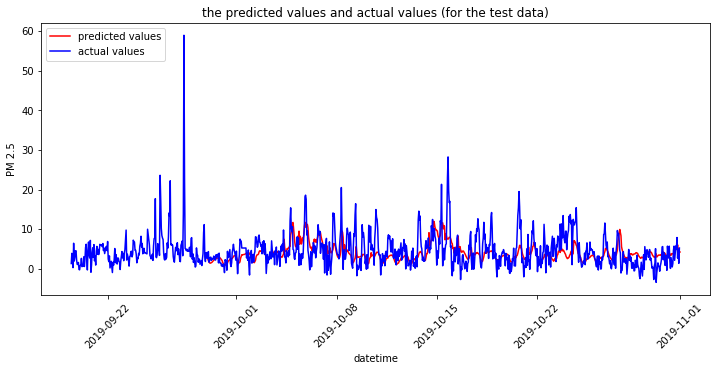

In [38]:
# plot the predicted values and actual values
plot_result(test_df, pred_df, pred_value_col="NO0060A.PM2.5_23", test_value_col="NO0060A.PM2.5")

In [25]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)
rmse, mape = pipeline.evaluate(test_df, metrics=["rmse", "mape"])
print("Evaluate: the root mean square error is", rmse)
print("Evaluate: the mape value is", mape)

Evaluate: the mean square error is [ 8.04431209 11.15359989 13.37585244 14.5078297  14.97843538 15.19201803
 14.98254672 14.76264375 14.25153117 13.77938101 13.70041577 13.92744446
 14.29758918 14.89950271 15.36055104 15.7826677  16.00961953 16.08847666
 15.99047891 15.99960662 15.89002057 15.62499341 15.74562767 16.24645165]
Evaluate: the smape value is [29.00533636 30.97624792 32.45756775 33.44235802 34.05917501 34.74587117
 34.98010653 35.02969843 34.9489377  34.66110366 34.60218014 34.89473476
 35.20701488 35.52671754 35.78526306 36.21715548 36.48554862 36.57810238
 36.50889427 36.41998038 36.39165604 36.3447589  36.3484116  36.54195207]
Evaluate: the root mean square error is [2.83624965 3.33970057 3.65730125 3.8089145  3.87019836 3.89769394
 3.87072948 3.8422186  3.77512002 3.71205886 3.70140727 3.73194915
 3.78121531 3.8599874  3.91925389 3.97274058 4.00120226 4.01104434
 3.99880969 3.99995083 3.98622887 3.95284624 3.96807607 4.03068873]
Evaluate: the mape value is [288.17946057

## Save and restore


In [26]:
# save the pipeline with best trial
pipeline.save("./my2.ppl")

Pipeline is saved in ./my2.ppl


'./my2.ppl'

In [28]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("my2.ppl")

Seq2seq is selected.
Restore pipeline from my2.ppl


In [29]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [30]:
new_pred.head(5)

datetime  NO0060A.PM2.5_0  NO0060A.PM2.5_1  NO0060A.PM2.5_2  \
0 2019-09-28 20:00:00         3.616927         3.255661         2.883390   
1 2019-09-28 21:00:00         2.947266         2.653796         2.366994   
2 2019-09-28 22:00:00         3.351608         2.916803         2.553999   
3 2019-09-28 23:00:00         3.251520         2.825341         2.499032   
4 2019-09-29 00:00:00         2.727149         2.406773         2.193377   

   NO0060A.PM2.5_3  NO0060A.PM2.5_4  NO0060A.PM2.5_5  NO0060A.PM2.5_6  \
0         2.564682         2.328618         2.179598         2.111640   
1         2.146180         2.008880         1.952819         1.967511   
2         2.302991         2.172083         2.146126         2.200935   
3         2.300483         2.228664         2.259472         2.360195   
4         2.099444         2.115039         2.211668         2.354066   

   NO0060A.PM2.5_7  NO0060A.PM2.5_8  ...  NO0060A.PM2.5_14  NO0060A.PM2.5_15  \
0         2.113623         2.171016  ...          2.791880          2.848168   
1         2.037806         2.145820  ...          2.757675          2.802647   
2         2.308931         2.442668  ...          2.920174          2.941767   
3         2.496696         2.638440  ...          2.977698          2.998166   
4         2.508441         2.648098  ...          2.956830          2.997212   

   NO0060A.PM2.5_16  NO0060A.PM2.5_17  NO0060A.PM2.5_18  NO0060A.PM2.5_19  \
0          2.890131          2.924647          2.958024          2.993845   
1          2.840850          2.878001          2.916605          2.955007   
2          2.966615          2.997184          3.030013          3.056869   
3          3.027577          3.060828          3.087111          3.093423   
4          3.040582          3.074348          3.083719          3.056043   

   NO0060A.PM2.5_20  NO0060A.PM2.5_21  NO0060A.PM2.5_22  NO0060A.PM2.5_23  
0          3.031674          3.067060          3.092822          3.101109  
1          2.987795          3.007374          3.006140          2.978536  
2          3.067322          3.051770          3.003970          2.922479  
3          3.068372          3.005102          2.902742          2.766306  
4          2.984050          2.867321          2.712021          2.529354  

[5 rows x 25 columns]

In [31]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)
rmse, mape = pipeline.evaluate(test_df, metrics=["rmse", "mape"])
print("Evaluate: the root mean square error is", rmse)
print("Evaluate: the mape value is", mape)

Evaluate: the mean square error is [ 8.04431209 11.15359989 13.37585244 14.5078297  14.97843538 15.19201803
 14.98254672 14.76264375 14.25153117 13.77938101 13.70041577 13.92744446
 14.29758918 14.89950271 15.36055104 15.7826677  16.00961953 16.08847666
 15.99047891 15.99960662 15.89002057 15.62499341 15.74562767 16.24645165]
Evaluate: the smape value is [29.00533636 30.97624792 32.45756775 33.44235802 34.05917501 34.74587117
 34.98010653 35.02969843 34.9489377  34.66110366 34.60218014 34.89473476
 35.20701488 35.52671754 35.78526306 36.21715548 36.48554862 36.57810238
 36.50889427 36.41998038 36.39165604 36.3447589  36.3484116  36.54195207]
Evaluate: the root mean square error is [2.83624965 3.33970057 3.65730125 3.8089145  3.87019836 3.89769394
 3.87072948 3.8422186  3.77512002 3.71205886 3.70140727 3.73194915
 3.78121531 3.8599874  3.91925389 3.97274058 4.00120226 4.01104434
 3.99880969 3.99995083 3.98622887 3.95284624 3.96807607 4.03068873]
Evaluate: the mape value is [288.17946057

## Continue training

In [32]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 24
dt_col: datetime
target_col: NO0060A.PM2.5
extra_features_col: ['SN68860:0.air_temperature', 'SN68860:0.relative_humidity', 'SN68860:0.sum(duration_of_precipitation PT1H)', 'SN68860:0.sum(precipitation_amount PT1H)', 'SN68860:0.surface_air_pressure', 'SN68860:0.wind_from_direction', 'SN68860:0.wind_speed']
drop_missing: True



In [33]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Train on 773 samples
Epoch 1/5
773/773 [==============================] - 12s 16ms/sample - loss: 0.1272 - mean_squared_error: 0.1272
Epoch 2/5
773/773 [==============================] - 6s 8ms/sample - loss: 0.1241 - mean_squared_error: 0.1241
Epoch 3/5
773/773 [==============================] - 5s 7ms/sample - loss: 0.1254 - mean_squared_error: 0.1254
Epoch 4/5
773/773 [==============================] - 5s 7ms/sample - loss: 0.1362 - mean_squared_error: 0.1362
Epoch 5/5
773/773 [==============================] - 5s 7ms/sample - loss: 0.1282 - mean_squared_error: 0.1282
Fit done!


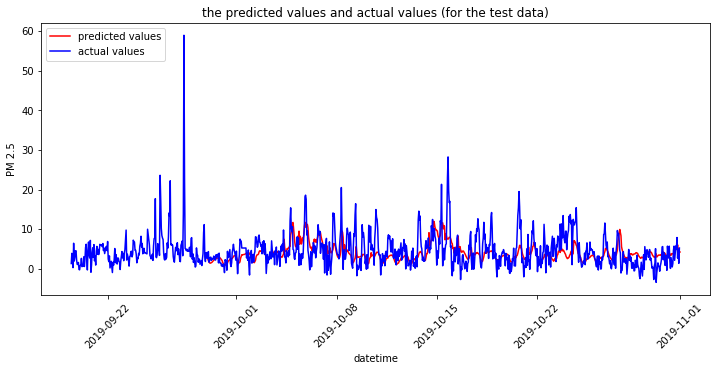

In [39]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, pred_df, pred_value_col="NO0060A.PM2.5_23", test_value_col="NO0060A.PM2.5")

In [36]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)
rmse, mape = pipeline.evaluate(test_df, metrics=["rmse", "mape"])
print("Evaluate: the root mean square error is", rmse)
print("Evaluate: the mape value is", mape)

Evaluate: the mean square error is [ 8.78510073 12.02121718 14.29893322 15.62364557 16.34807869 16.78749971
 16.93728392 16.9750778  16.74333383 16.37881384 16.33326544 16.57141564
 16.64079221 17.04693854 17.33640101 17.73100726 17.95190661 17.94934905
 17.92767142 17.78309229 17.66158405 17.61150925 17.54388902 17.6285916 ]
Evaluate: the smape value is [30.67617174 32.92482596 34.67751521 35.95168595 36.88430059 37.67857212
 37.99139202 38.05817577 38.06094365 37.98902072 38.04912846 38.26805695
 38.38300994 38.55199376 38.5819521  38.69596461 38.6991682  38.75290563
 38.66444605 38.59775841 38.52068645 38.39339587 38.28051849 38.16605363]
Evaluate: the root mean square error is [2.83624965 3.33970057 3.65730125 3.8089145  3.87019836 3.89769394
 3.87072948 3.8422186  3.77512002 3.71205886 3.70140727 3.73194915
 3.78121531 3.8599874  3.91925389 3.97274058 4.00120226 4.01104434
 3.99880969 3.99995083 3.98622887 3.95284624 3.96807607 4.03068873]
Evaluate: the mape value is [288.17946057

## Multi step forecasting

In [ ]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="NO0060A.PM2.5",
                            extra_features_col=None)

In [ ]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

In [ ]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [ ]:
pred_df.head(5)

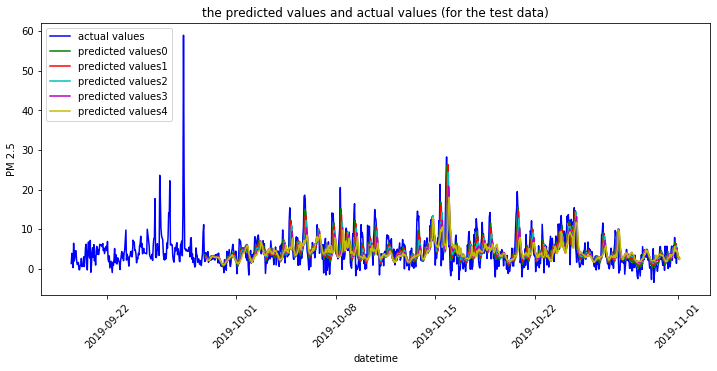

In [43]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df, value_col="NO0060A.PM2.5")

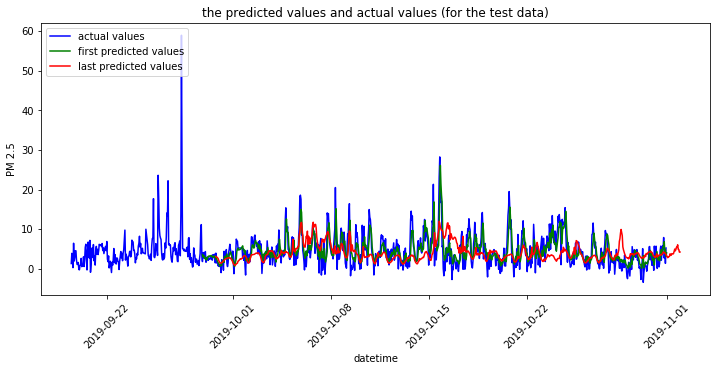

In [44]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df, value_col="NO0060A.PM2.5")

In [ ]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

In [ ]:
ray_ctx.stop()